<a href="https://colab.research.google.com/github/samaneh-m/TU-simulation-base-inference/blob/main/Model_withValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "bayesflow>=2.0"
!pip install tensorflow hmmlearn

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - loss: 36.1321 - val_loss: 18.7341
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: -11.3610 - val_loss: -7.7624
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -17.8151 - val_loss: -15.2506
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: -21.0879 - val_loss: -18.9804
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: -23.7748 - val_loss: -23.0963
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: -26.2299 - val_loss: -26.9961
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -28.3360 - val_loss: -30.4913
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: -30.5071 - val_loss: -33.5825
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: -32.3195 - val_loss: -35.5881
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: -34.0124 - val_loss: -37.8152
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: -35.2215 - val_loss: -39.901

       hidden_states_0  hidden_states_1  hidden_states_2  hidden_states_3  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.163212         0.197537         0.225248         0.241830   
std           0.128079         0.147981         0.162779         0.180100   
min           0.020702         0.035439         0.069386         0.090000   
25%           0.110466         0.133607         0.140793         0.142337   
50%           0.200230         0.231774         0.212200         0.194674   
75%           0.234468         0.278586         0.303179         0.317746   
max           0.268706         0.325398         0.394158         0.440817   

       hidden_states_4  hidden_states_5  hidden_states_6  hidden_states_7  \
count         3.000000         3.000000         3.000000         3.000000   
mean          0.262696         0.284862         0.303189         0.327356   
std           0.200361         0.216754         0.244809         0.252322  

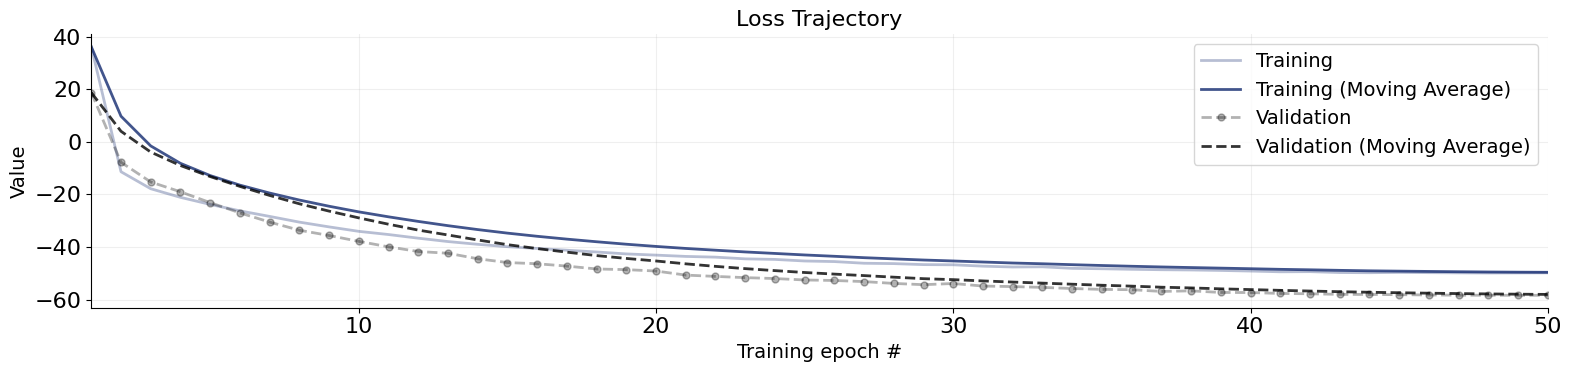

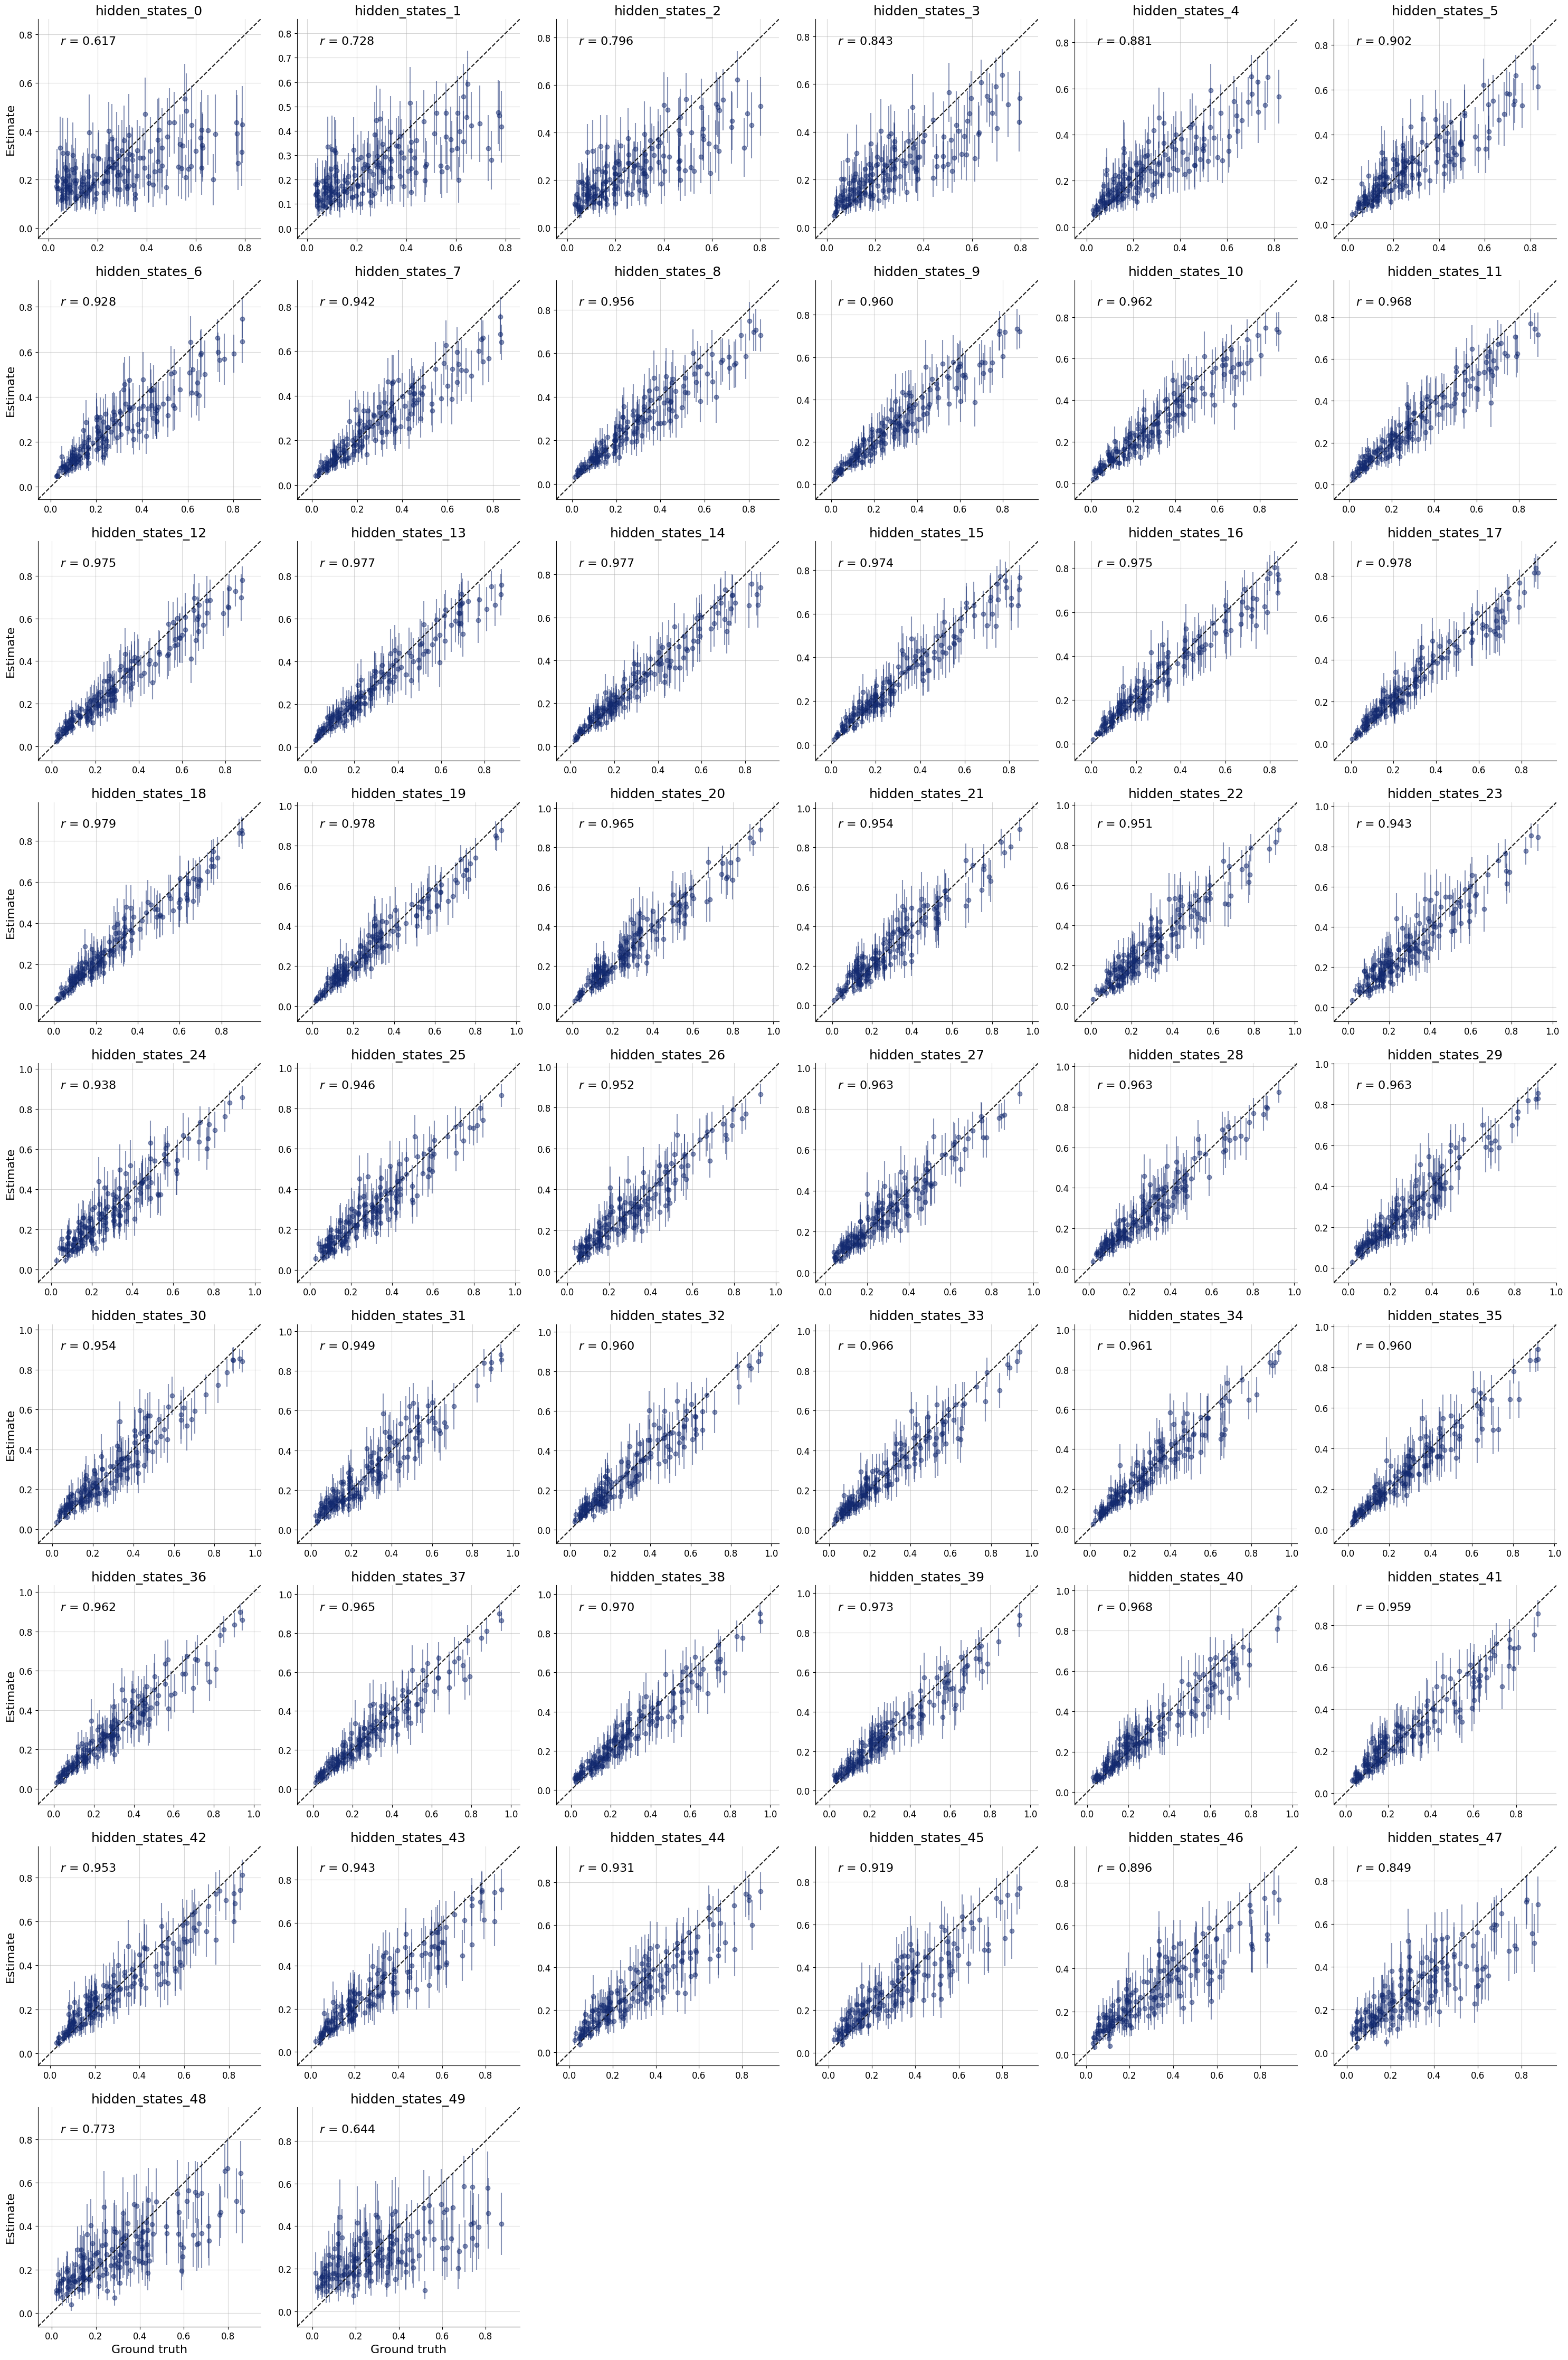

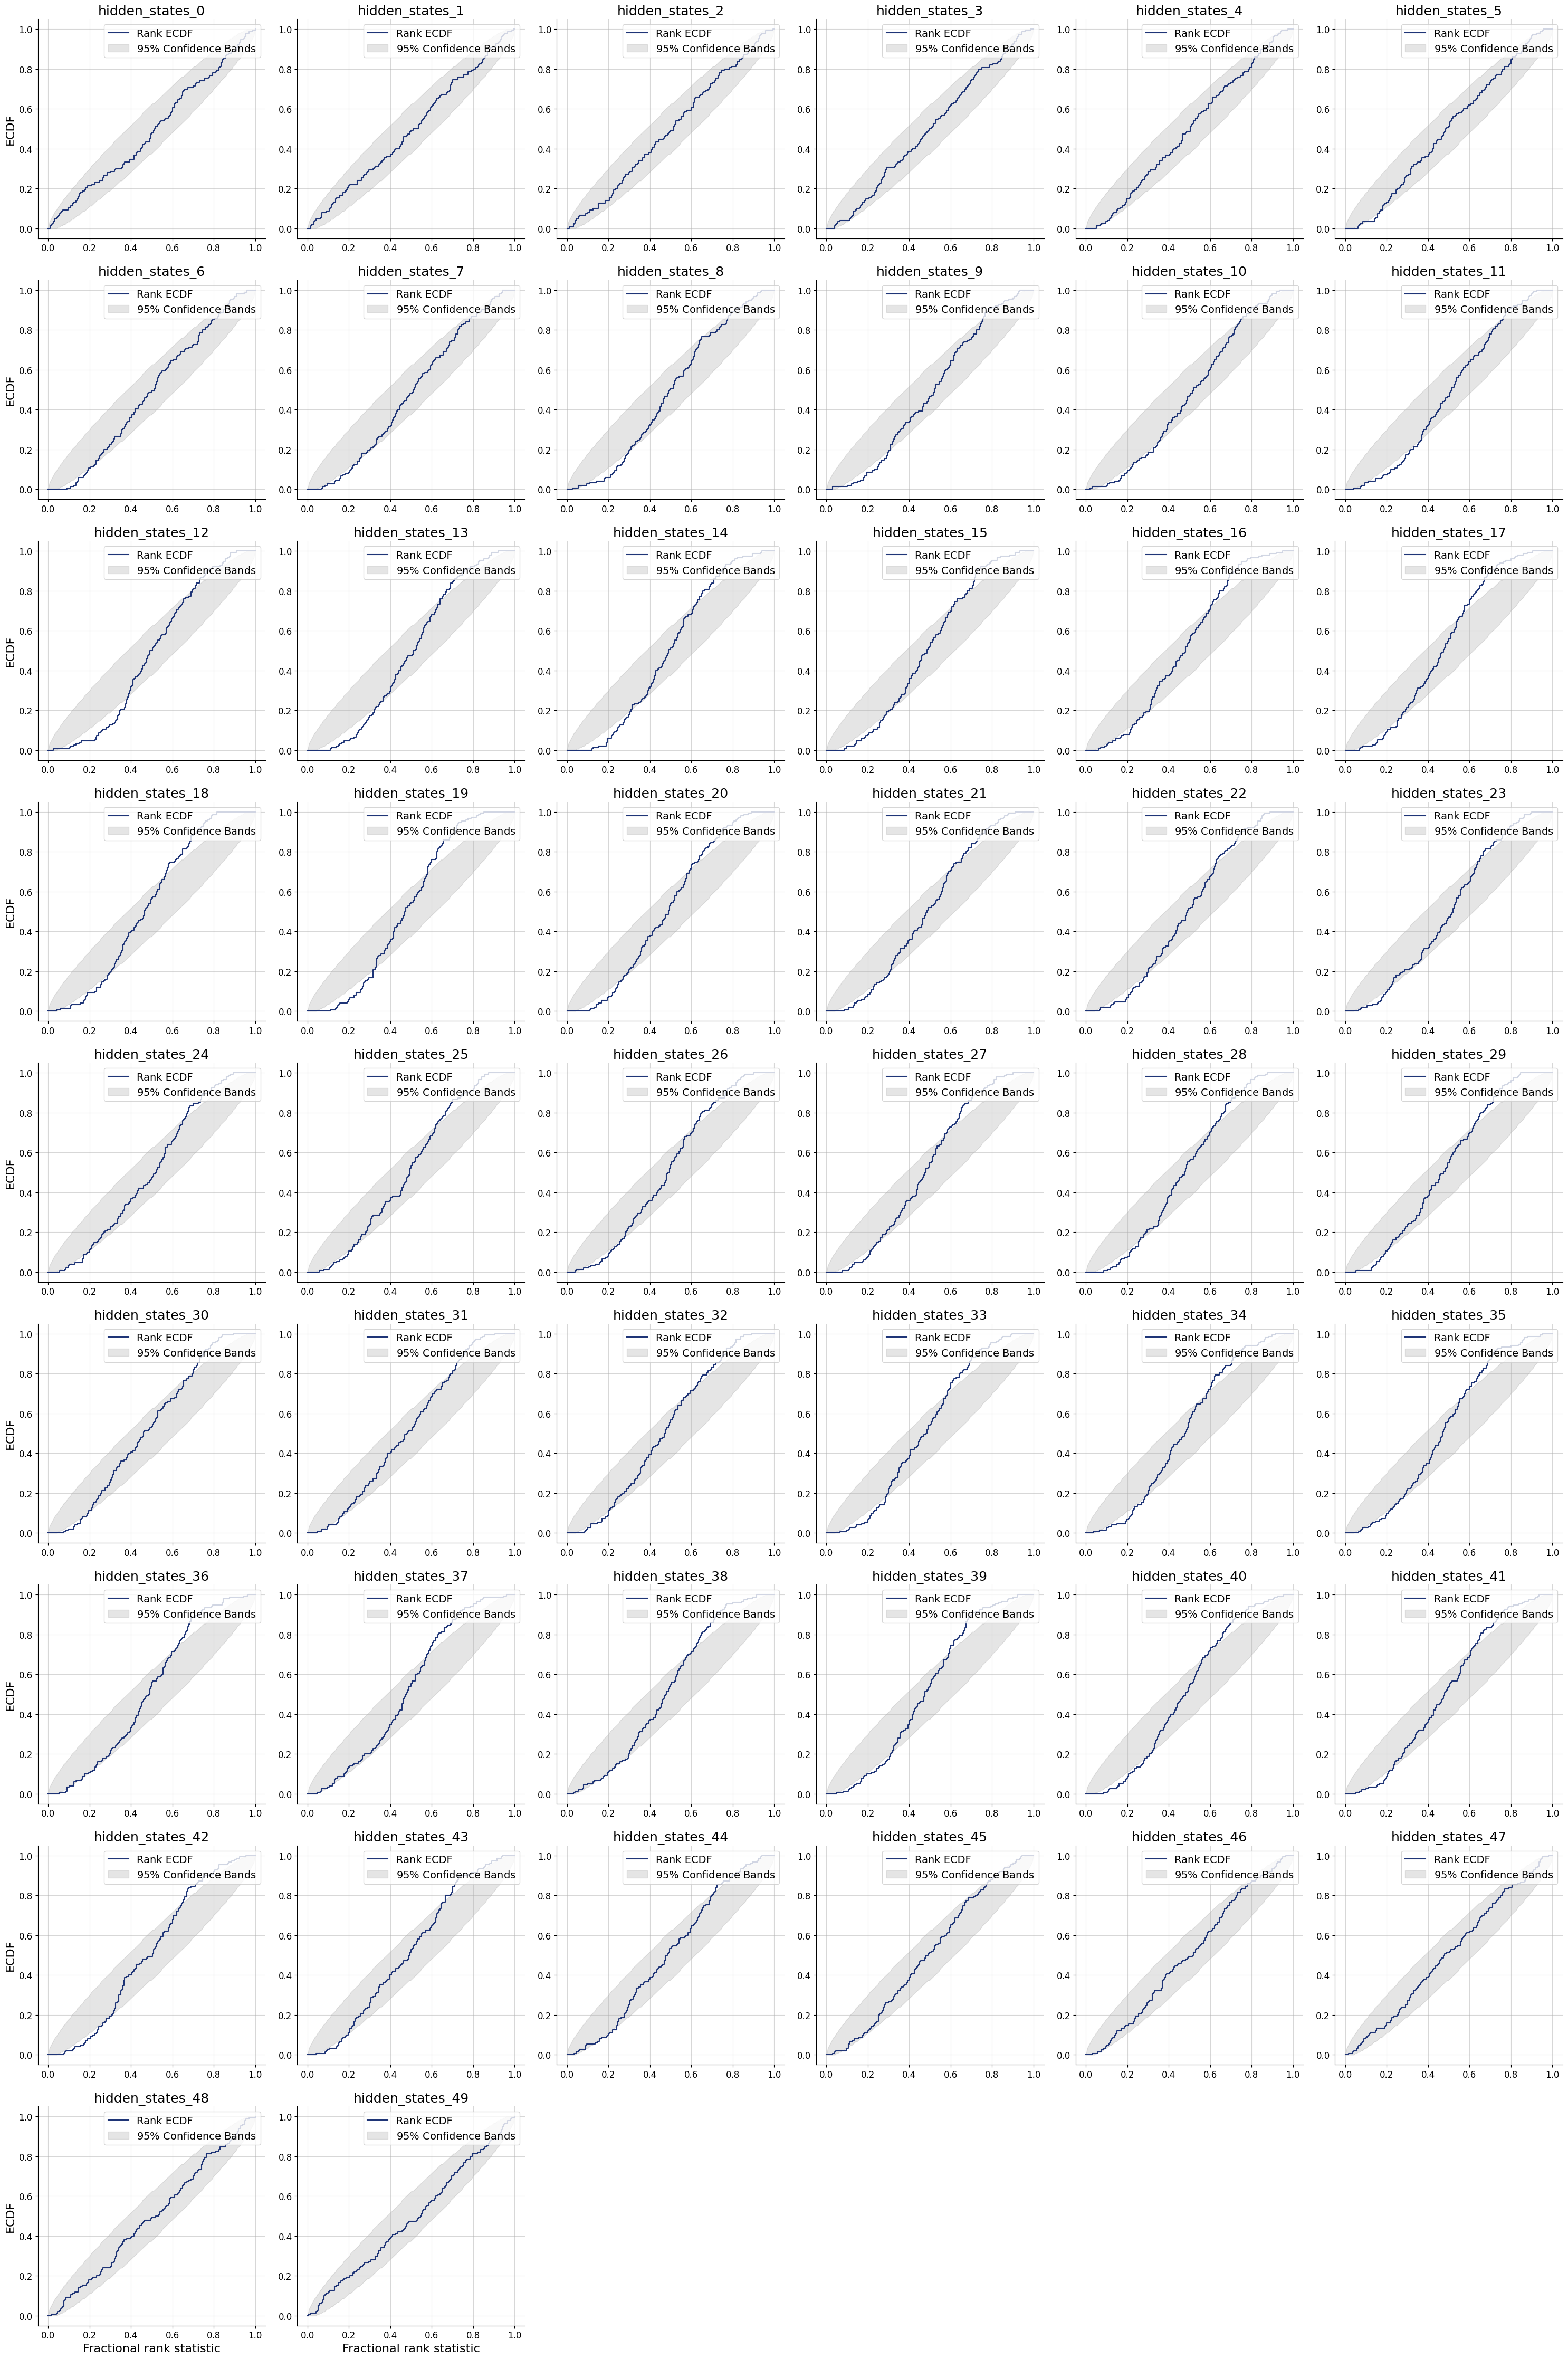

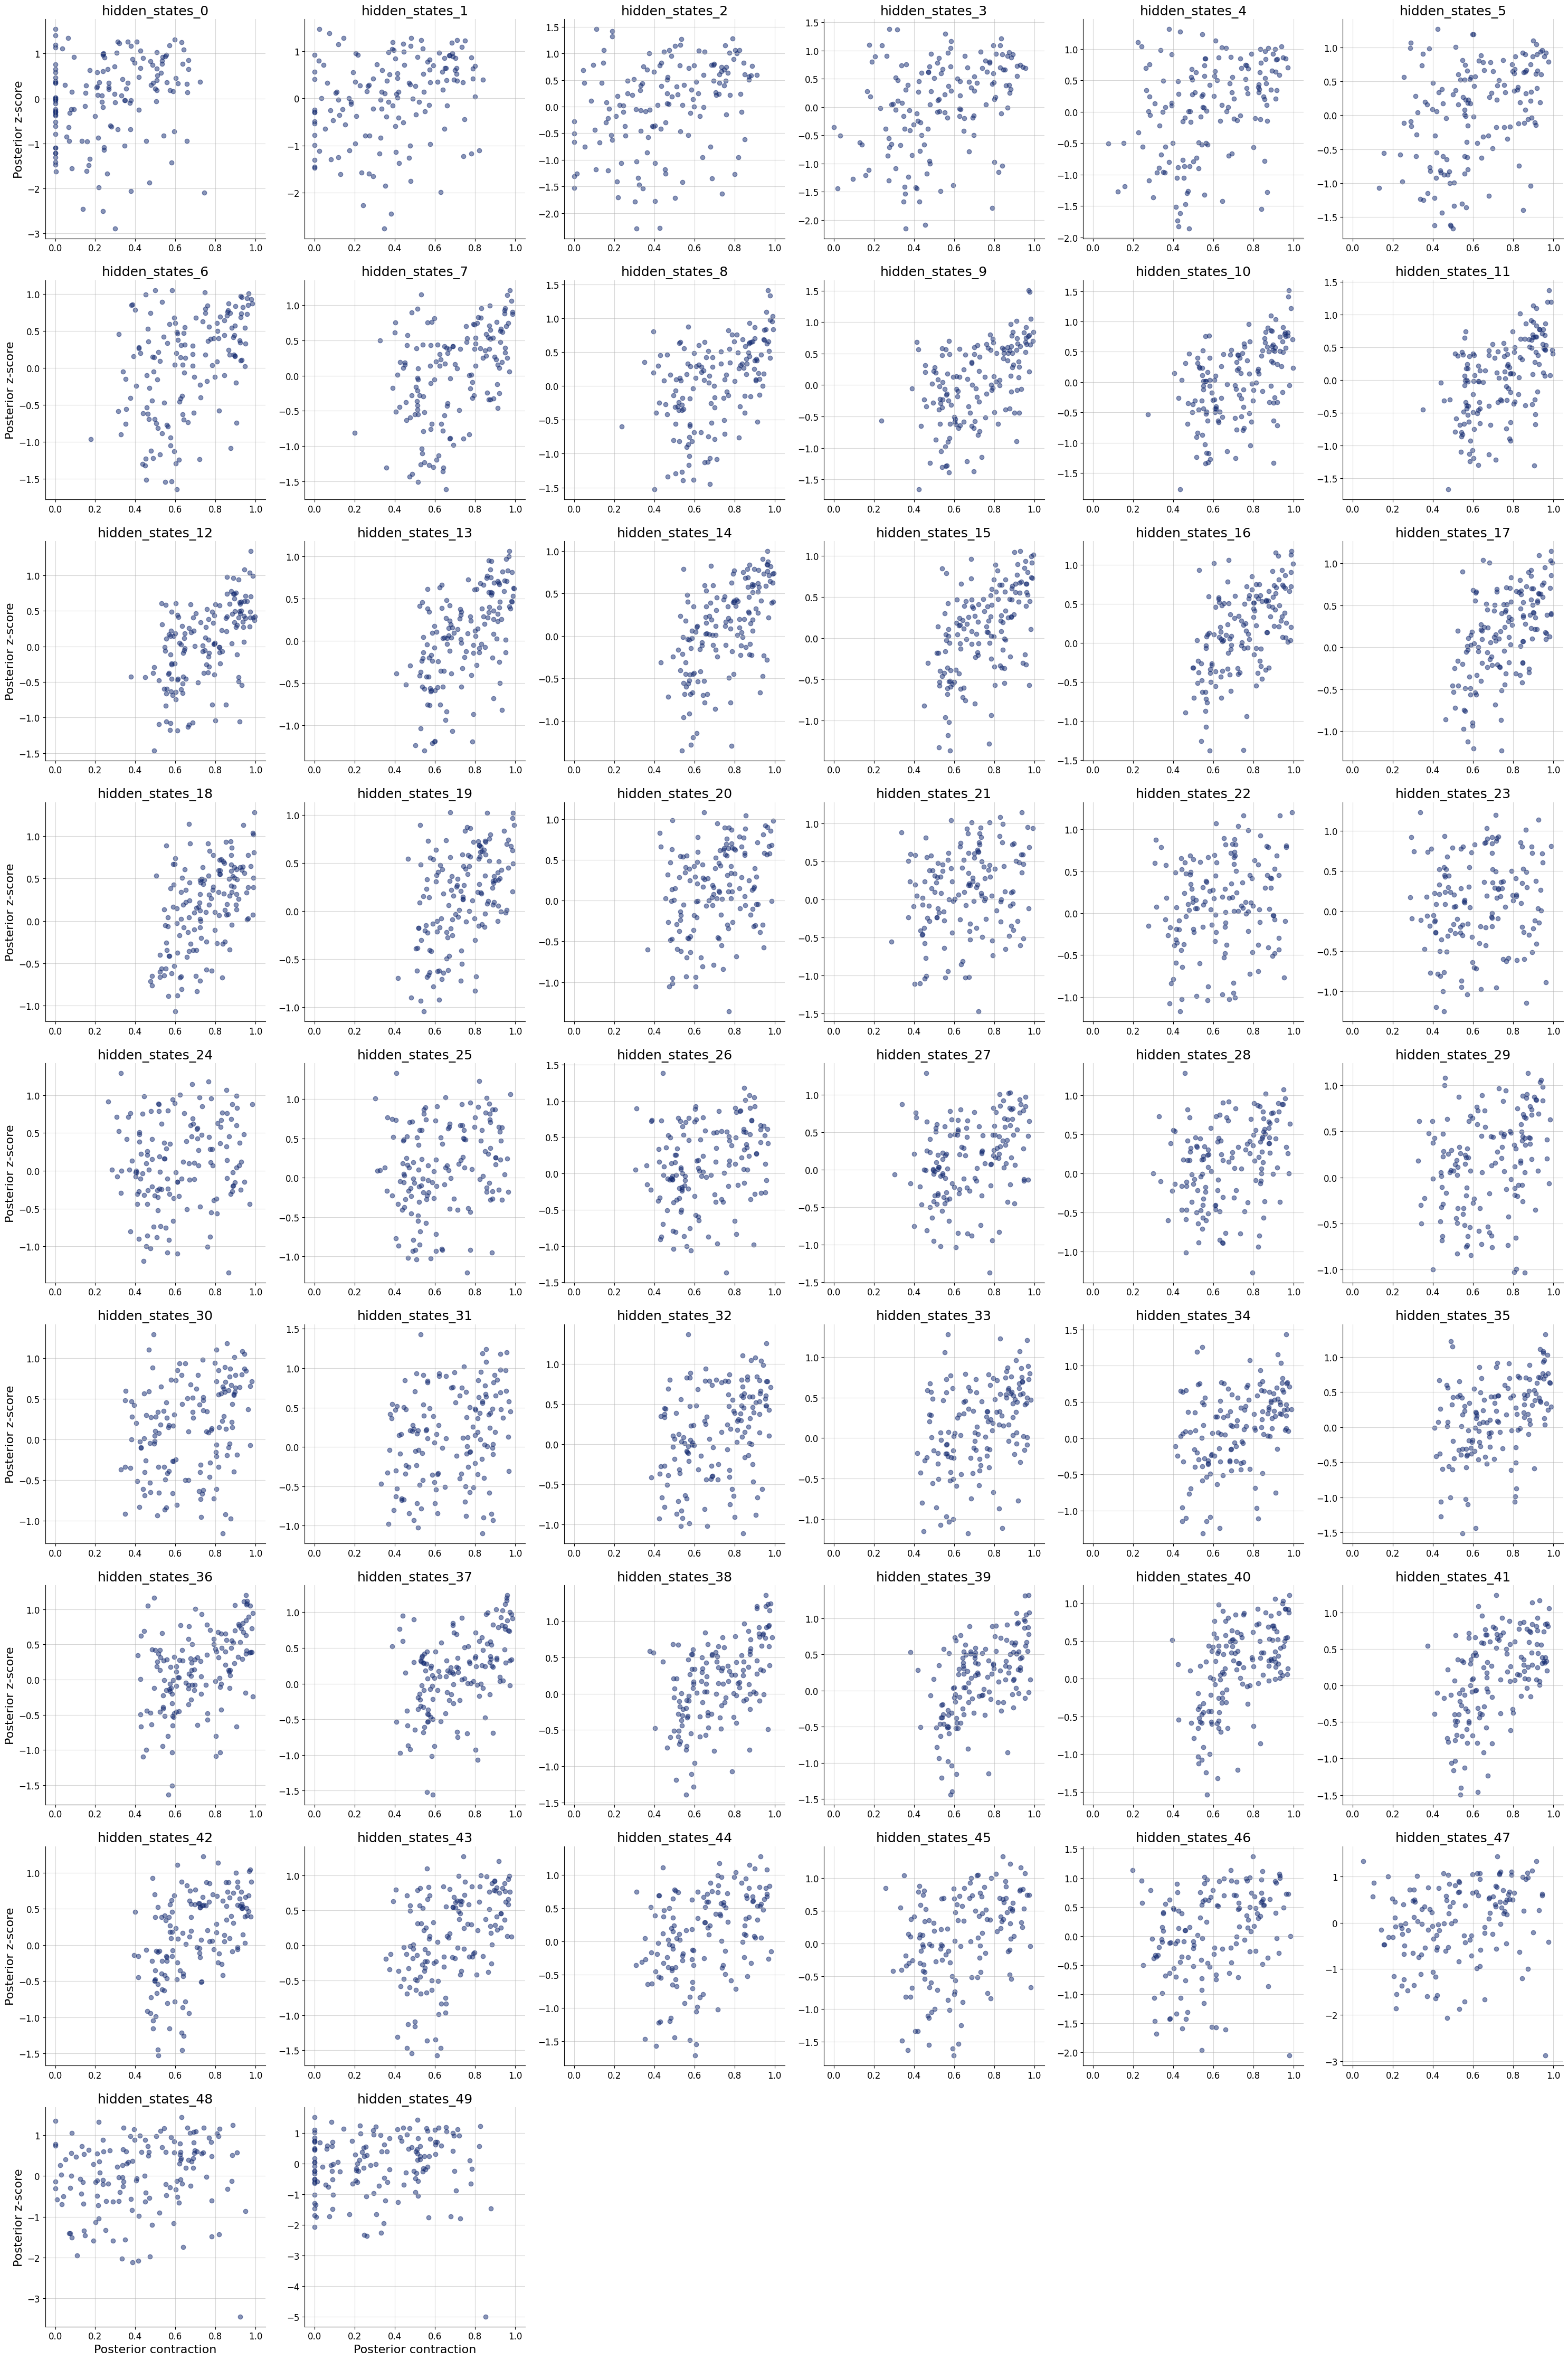

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import bayesflow as bf
import numpy as np
import tensorflow as tf
from hmmlearn import hmm
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

# --- Define amino acid mapping ---
amino_acids = ['A','R','N','D','C','E','Q','G','H','I',
               'L','K','M','F','P','S','T','W','Y','V']
aa_to_int = {aa:i for i, aa in enumerate(amino_acids)}

# --- Custom summary network as advised by professor ---
class CustomSummaryNetwork(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.network = tf.keras.Sequential([
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(256),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Dense(128),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.ReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Dense(64, activation="relu"),
])

    def call(self, x, **kwargs):
        return self.network(x, training=kwargs.get("stage") == "training")

    def compute_metrics(self, x, stage=None, **kwargs):
        summary = self.network(x, training=stage == "training")
        return {"outputs": summary}


# --- HMM simulator for training data ---
class HMMHiddenStateSimulator:
    def __init__(self, seq_len=50):
        self.seq_len = seq_len
        self.transmat = np.array([[0.90, 0.10],[0.05, 0.95]])
        self.startprob = np.array([0.0, 1.0])
        emissions = {
            'alpha': np.array([12,6,3,5,1,9,5,4,2,7,12,6,3,4,2,5,4,1,3,6]) / 100,
            'other': np.array([6,5,5,6,2,5,3,9,3,5,8,6,2,4,6,7,6,1,4,7]) / 100
        }
        self.emissionprob = np.stack([emissions['alpha'], emissions['other']])
        self.model = hmm.CategoricalHMM(n_components=2, n_iter=100, init_params="")
        self.model.startprob_ = self.startprob
        self.model.transmat_ = self.transmat
        self.model.emissionprob_ = self.emissionprob

    def sample(self, n_sequences=30000):
        X = []
        for _ in range(n_sequences):
            seq, _ = self.model.sample(n_samples=self.seq_len)
            X.append(seq.flatten())
        X_all = np.concatenate(X).reshape(-1, 1)
        post_probs = self.model.predict_proba(X_all)
        theta_post = post_probs[:, 0].reshape(n_sequences, self.seq_len)
        x_obs = np.array(X).reshape(n_sequences, self.seq_len)
        return x_obs, theta_post

# --- Replay simulator wrapper ---
class ReplaySimulator:
    def __init__(self, x_data, theta_data):
        self.x = x_data
        self.theta = theta_data
        self.n = theta_data.shape[0]

    def sample(self, batch_size):
        idx = np.random.choice(self.n, size=batch_size, replace=False)
        return {"hidden_states": self.theta[idx], "observations": self.x[idx]}

# --- Simulate data and encode ---
sim = HMMHiddenStateSimulator(seq_len=50)
x_train, theta_train = sim.sample(n_sequences=1000)
x_train_onehot = to_categorical(x_train, num_classes=20)

# --- BayesFlow setup ---
N, seq_len, AA = x_train_onehot.shape

summary_net = CustomSummaryNetwork()

inference_net = bf.networks.CouplingFlow(
    n_parameters=50,
    context_summary=["observations"],
    coupling_layers=6,
    hidden_sizes=[128, 128]
)

simulator = ReplaySimulator(x_train_onehot, theta_train)

workflow = bf.BasicWorkflow(
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["hidden_states"],
    summary_variables=["observations"],
    simulator=simulator
)


from sklearn.model_selection import train_test_split

# Split into training and validation sets
x_train_split, x_val_split, theta_train_split, theta_val_split = train_test_split(
    x_train_onehot, theta_train, test_size=0.3, random_state=42
)


simulator = ReplaySimulator(x_train_split, theta_train_split)
val_simulator = ReplaySimulator(x_val_split, theta_val_split)
# Validation data as a dictionary
validation_data = {
    "observations": x_val_split,
    "hidden_states": theta_val_split
}



from sklearn.model_selection import train_test_split

# --- Simulate data and encode ---
sim = HMMHiddenStateSimulator(seq_len=50)
x_all, theta_all = sim.sample(n_sequences=30000)
x_all_onehot = to_categorical(x_all, num_classes=20)

# --- Split into training and validation sets ---
x_train, x_val, theta_train, theta_val = train_test_split(
    x_all_onehot, theta_all, test_size=0.2, random_state=42
)

# --- Create ReplaySimulator for training only ---
simulator = ReplaySimulator(x_train, theta_train)

# --- Create validation data dict ---
val_data = {
    "observations": x_val,
    "hidden_states": theta_val
}

# --- BayesFlow setup ---
summary_net = CustomSummaryNetwork()

inference_net = bf.networks.CouplingFlow(
    n_parameters=50,
    context_summary=["observations"],
    coupling_layers=6,
    hidden_sizes=[128, 128]
)

workflow = bf.BasicWorkflow(
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["hidden_states"],
    summary_variables=["observations"],
    simulator=simulator
)

# --- Train model with validation ---
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = workflow.fit_online(
    epochs=50,
    batch_size=64,
    num_batches_per_epoch=200,
    validation_data=validation_data,
    validation_batches=50,
    callbacks=[early_stop]
)

# --- Evaluate diagnostics ---
workflow.plot_diagnostics(test_data=150, num_samples=200)

df_metrics = workflow.compute_default_diagnostics(
    test_data=150,
    num_samples=200,
    as_data_frame=True
)
print(df_metrics.describe())

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ppc(samples, obs_sequences, logscale=False, color="#132a70", figsize=(12, 6), font_size=18):
    """
    Posterior predictive check for HMM hidden states.
    Assumes samples has shape [n_samples, batch_size, sequence_length]
    and obs_sequences has shape [batch_size, sequence_length]
    """
    plt.rcParams["font.size"] = font_size
    f, ax = plt.subplots(1, 1, figsize=figsize)
    T = obs_sequences.shape[1]

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(samples, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(samples, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(samples, q=[0.025, 0.975], axis=0)
    median_pred = np.median(samples, axis=0)

    # Compute mean across sequences for plotting
    median_curve = median_pred.mean(axis=0)
    true_curve = obs_sequences.mean(axis=0)

    ax.plot(median_curve, label="Median predicted hidden state", color=color)
    ax.plot(true_curve, marker="o", label="True hidden state", color="black", linestyle="dashed", alpha=0.8)
    ax.fill_between(range(T), qs_50[0].mean(axis=0), qs_50[1].mean(axis=0), color=color, alpha=0.5, label="50% CI")
    ax.fill_between(range(T), qs_90[0].mean(axis=0), qs_90[1].mean(axis=0), color=color, alpha=0.3, label="90% CI")
    ax.fill_between(range(T), qs_95[0].mean(axis=0), qs_95[1].mean(axis=0), color=color, alpha=0.1, label="95% CI")

    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Sequence Position")
    ax.set_ylabel("Hidden State Probability")
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")
    ax.legend(fontsize=font_size)

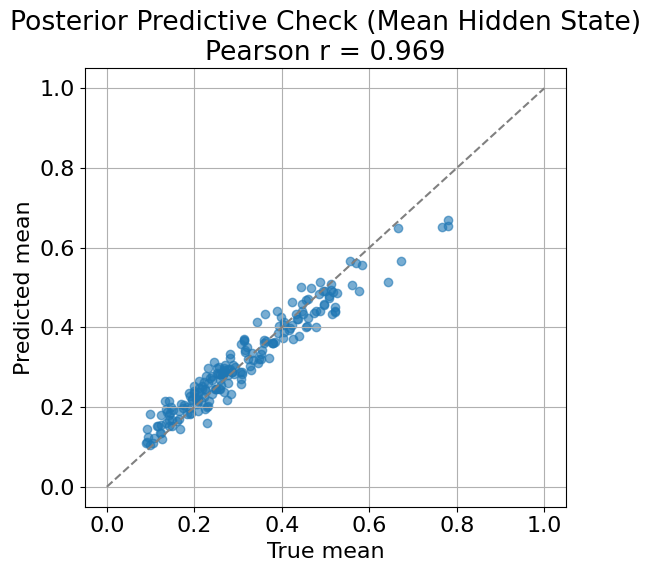

In [8]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Simulate test scenarios from the prior ---
num_datasets = 200  # e.g., number of synthetic test cases
num_samples = 100   # posterior samples per case

test_sims = workflow.simulate(num_datasets)

# --- 2. Use already one-hot encoded observations ---
test_obs_onehot = test_sims["observations"]  # shape: (200, 50, 20)
true_states = test_sims["hidden_states"]     # shape: (200, 50)

# --- 3. Run inference to get posterior samples ---
posterior = workflow.sample(
    conditions={"observations": test_obs_onehot},
    num_samples=num_samples
)
posterior_samples = posterior["hidden_states"]  # shape: (100, 200, 50)

# --- 4. Compute posterior mean estimates ---
pred_states = posterior_samples.mean(axis=1)  # shape: (200, 50)

# --- 5. Mean across sequence positions ---
true_seq_mean = true_states.mean(axis=1)  # shape: (200,)
pred_seq_mean = pred_states.mean(axis=1)  # shape: (200,)

# print("True mean shape:", true_seq_mean.shape)
# print("Pred mean shape:", pred_seq_mean.shape)

# --- 6. Correlation and plot ---
r, _ = pearsonr(true_seq_mean, pred_seq_mean)

plt.figure(figsize=(6, 6))
plt.scatter(true_seq_mean, pred_seq_mean, alpha=0.6)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title(f"Posterior Predictive Check (Mean Hidden State)\nPearson r = {r:.3f}")
plt.xlabel("True mean")
plt.ylabel("Predicted mean")
plt.grid(True)
plt.tight_layout()
plt.show()

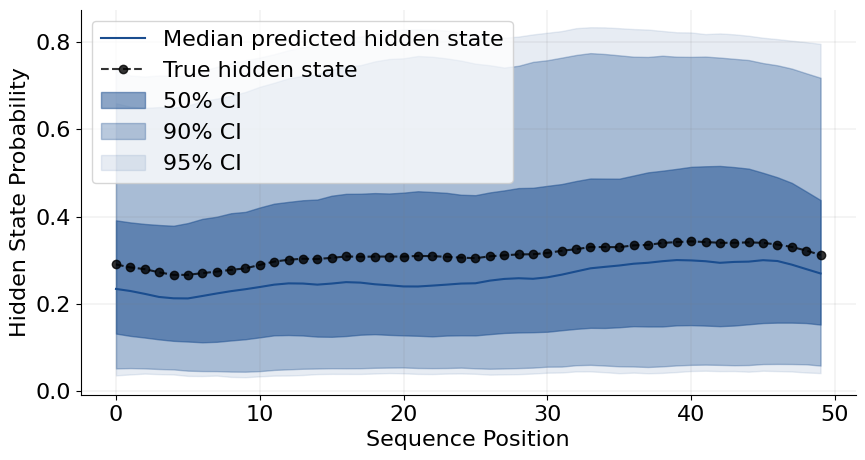

In [9]:
plot_ppc(posterior_samples, true_states, logscale=False, color="#1a4d8f", figsize=(10, 5), font_size=16)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from statsmodels.distributions.empirical_distribution import ECDF


In [35]:
import numpy as np

def rank_samples(posterior_samples, true_values):
    """
    Computes SBC ranks for each test case and dimension.

    posterior_samples: shape (n_samples, n_datasets, seq_len)
    true_values: shape (n_datasets, seq_len)

    Returns:
        ranks: shape (n_datasets, seq_len), the SBC rank of each true value
    """
    n_samples, n_datasets, seq_len = posterior_samples.shape
    ranks = np.zeros((n_datasets, seq_len), dtype=int)

    for i in range(n_datasets):
        for j in range(seq_len):
            ranks[i, j] = np.sum(posterior_samples[:, i, j] < true_values[i, j])
    return ranks

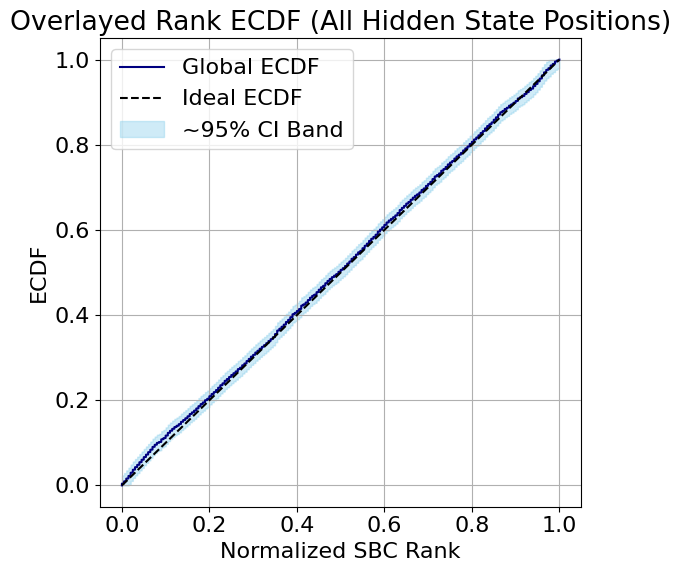

In [36]:
# Compute ranks
ranks = rank_samples(posterior_samples, true_states)  # shape: (n_datasets, seq_len)

# Normalize to [0, 1]
normalized_ranks = ranks / posterior_samples.shape[0]

# Flatten across all positions and all datasets
all_ranks = normalized_ranks.flatten()

# Plot global ECDF
sorted_ranks = np.sort(all_ranks)
ecdf = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(sorted_ranks, ecdf, label="Global ECDF", color="navy")
plt.plot([0, 1], [0, 1], "--", color="black", label="Ideal ECDF")

# Add approximate confidence band (Kolmogorov-Smirnov based)
n = len(all_ranks)
epsilon = 1.36 / np.sqrt(n)
plt.fill_between(sorted_ranks, np.maximum(ecdf - epsilon, 0), np.minimum(ecdf + epsilon, 1),
                 color="skyblue", alpha=0.4, label="~95% CI Band")

plt.title("Overlayed Rank ECDF (All Hidden State Positions)")
plt.xlabel("Normalized SBC Rank")
plt.ylabel("ECDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

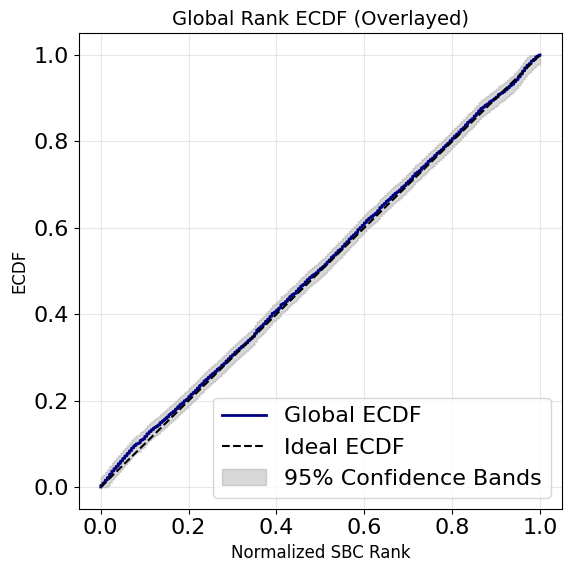

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# --- Assume `ranks_flat` is your 1D array of normalized SBC ranks ---
# ranks_flat shape: (num_positions * num_test_cases,)

# Compute global ECDF
ecdf = ECDF(all_ranks)
x = ecdf.x
y = ecdf.y

# --- Confidence bands ---
n = len(all_ranks)
alpha = 0.05
epsilon = np.sqrt(np.log(2/alpha) / (2 * n))  # Dvoretzky-Kiefer-Wolfowitz (DKW) bound
lower = np.maximum(y - epsilon, 0)
upper = np.minimum(y + epsilon, 1)

# --- Plot ---
plt.figure(figsize=(6, 6))  # Square aspect like your subplot
plt.plot(x, y, label="Global ECDF", color="navy", lw=2)
plt.plot([0, 1], [0, 1], "k--", label="Ideal ECDF", lw=1.5)
plt.fill_between(x, lower, upper, color="gray", alpha=0.3, label="95% Confidence Bands")

# --- Labels and style ---
plt.xlabel("Normalized SBC Rank", fontsize=12)
plt.ylabel("ECDF", fontsize=12)
plt.title("Global Rank ECDF (Overlayed)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
